In [1]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
import torch.utils.data as data
import dill as pickle
import random

In [2]:
manualSeed = 13
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  13


In [3]:
def show_img_and_mask(img, mask):
    fig,ax = plt.subplots(figsize=(12,12))
    ax.imshow(img.reshape(100, 360), cmap='gray')
    ax.imshow(mask.reshape(100, 360), alpha=.1, cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
def show_batch(images, masks):
    img_number = 0
    if len(images) % 2:
        fig,ax = plt.subplots(len(images)//2+1, 2, figsize=(20,20))
    else:
        fig,ax = plt.subplots(len(images)//2, 2, figsize=(20,20))
       
    for i in range(len(images)//2):
        ax[i, 0].imshow(images[img_number].reshape(100,360), cmap='gray')
        ax[i, 0].imshow(masks[img_number].reshape(100,360), alpha=.1, cmap='binary')
        img_number = img_number + 1
        ax[i, 1].imshow(images[img_number].reshape(100,360), cmap='gray')
        ax[i, 1].imshow(masks[img_number].reshape(100,360), alpha=.1, cmap='binary')
        img_number = img_number + 1
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()

In [5]:
def show_side_by_side(images, masks, predictions):
    img_number = 0
    fig,ax = plt.subplots(len(images), 2, figsize=(20,20))
       
    for i in range(len(images)):
        ax[i, 0].imshow(images[img_number].reshape(100,360), cmap='gray')
        ax[i, 0].imshow(masks[img_number].reshape(100,360), alpha=.1, cmap='binary')
        ax[i, 1].imshow(images[img_number].reshape(100,360), cmap='gray')
        ax[i, 1].imshow(predictions[img_number].reshape(100,360), alpha=.1, cmap='binary')
        img_number = img_number + 1
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()

In [6]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, valid_split=False):
        super(DataLoaderSegmentation, self).__init__()
        
        mask_location = '{}/final_masks.pkl'.format(folder_path)
        image_location = '{}/final_images.pkl'.format(folder_path)
        self.training_masks = []
        self.training_images = []
        self.valid_images = []
        self.valid_masks = []
        
        with open(mask_location, 'rb') as file:
            temp_mask_files = pickle.load(file)
            
        with open(image_location, 'rb') as file:
            temp_image_files = pickle.load(file)
                
        if valid_split:
            random_indexes = list(range(len(temp_image_files)))
            random.shuffle(random_indexes)
            self.valid_images = [ temp_image_files[x] for x in random_indexes[:len(temp_image_files)//5] ]
            self.training_images = [ temp_image_files[x] for x in random_indexes[len(temp_image_files)//5:] ]
            self.valid_masks = [ temp_mask_files[x] for x in random_indexes[:len(temp_mask_files)//5] ]
            self.training_masks = [ temp_mask_files[x] for x in random_indexes[len(temp_mask_files)//5:] ]
            
        else:
            self.training_images = temp_image_files
            self.training_masks = temp_mask_files
    
    def get_valid_batch(self, nitems):
        random_indexes = list(range(len(self.valid_images)))
        random.shuffle(random_indexes)
        valid_images_sample = [ self.valid_images[x] for x in random_indexes[:nitems] ]
        valid_masks_sample = [ self.valid_masks[x] for x in random_indexes[:nitems] ]
        return torch.FloatTensor(valid_images_sample), torch.FloatTensor(valid_masks_sample)
        
    def __getitem__(self, index):
            return torch.from_numpy(self.training_images[index]).float(), torch.from_numpy(self.training_masks[index]).float()

    def __len__(self):
        return len(self.training_images)

In [24]:
dataset = DataLoaderSegmentation('data/pickles', True)

In [25]:
dataloader = data.DataLoader(dataset, shuffle=True, batch_size=10)

In [15]:
for images, masks in dataloader:
    break

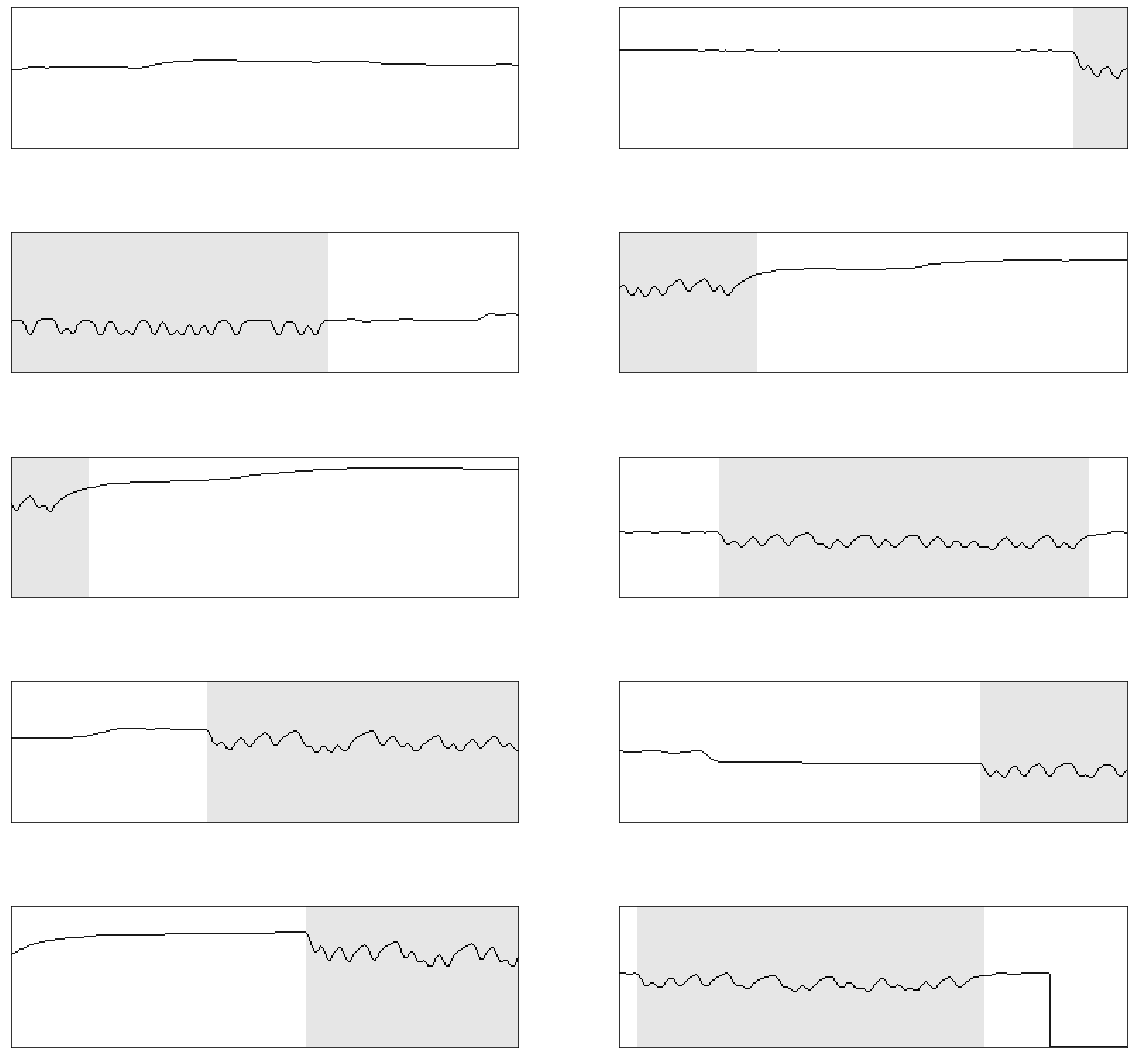

In [16]:
show_batch(images, masks)

In [19]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    ) 

def upsample(size):
    return nn.Upsample(size=size, mode='bilinear', align_corners=True) 

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = conv(1, 64)
        self.dconv_down2 = conv(64, 128)
        self.dconv_down3 = conv(128, 256)
        self.dconv_down4 = conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample1 = upsample((25,90))
        self.upsample2 = upsample((50,180))
        self.upsample3 = upsample((100,360))
        
        self.dconv_up3 = conv(256 + 512, 256)
        self.dconv_up2 = conv(128 + 256, 128)
        self.dconv_up1 = conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_down4(x)
        
        x = self.upsample1(x)
        
        # copy the weights over
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample2(x)        
        
        # copy the weights over
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample3(x)   
        
        # copy the weights over
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [18]:
model = UNet(2)
model.cuda()

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [12]:
# variables
epochs = 10
running_loss = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001

criterion = nn.NLLLoss()
optimizer = opt.Adam(model.parameters(), lr=learning_rate)

10 epochs, 96 total_steps per epoch
Epoch [1/10], Step [10/96], Loss: 0.665860
Epoch [1/10], Step [20/96], Loss: 0.687120
Epoch [1/10], Step [30/96], Loss: 0.710786
Epoch [1/10], Step [40/96], Loss: 0.699292
Epoch [1/10], Step [50/96], Loss: 0.686521
Epoch [1/10], Step [60/96], Loss: 0.679743
Epoch [1/10], Step [70/96], Loss: 0.695120
Epoch [1/10], Step [80/96], Loss: 0.680667
Epoch [1/10], Step [90/96], Loss: 0.632029


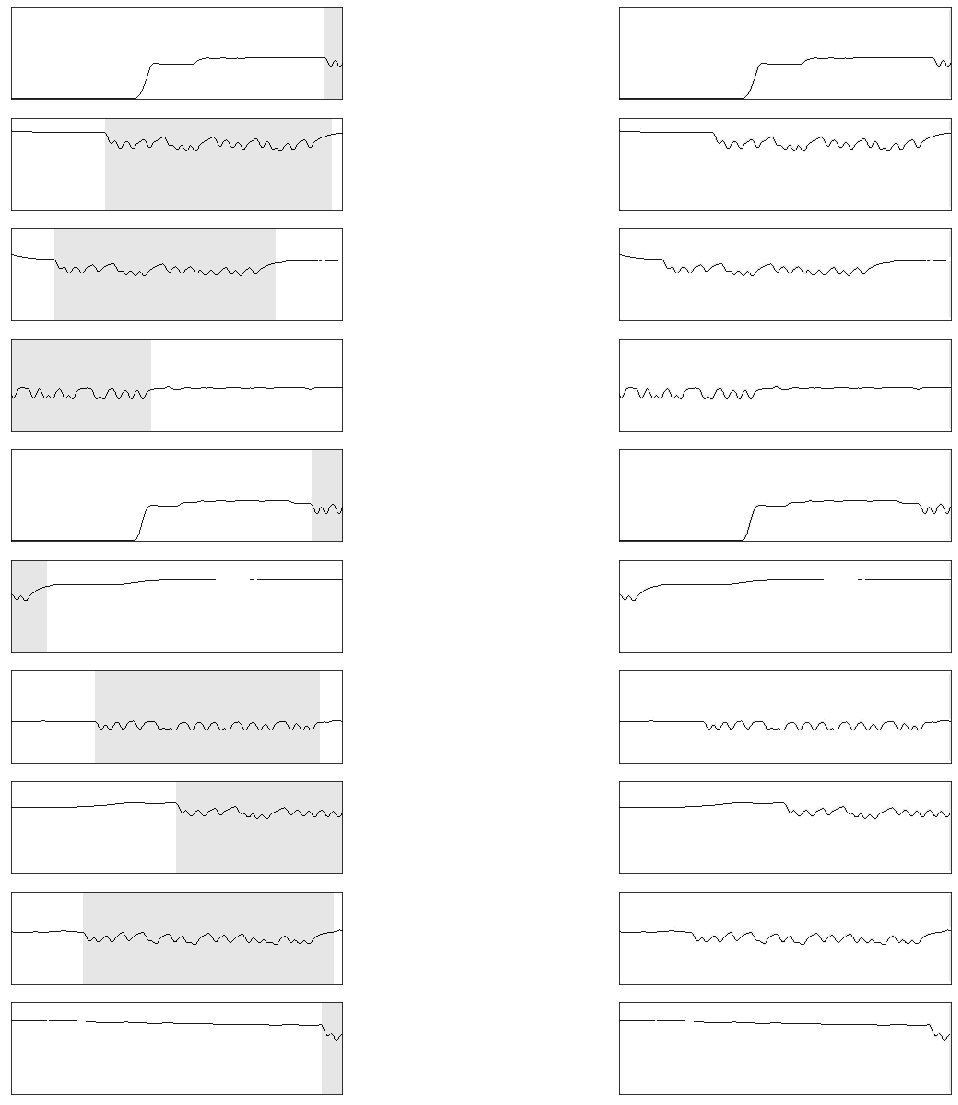

Epoch [2/10], Step [10/96], Loss: 0.680251
Epoch [2/10], Step [20/96], Loss: 0.713440
Epoch [2/10], Step [30/96], Loss: 0.684885
Epoch [2/10], Step [40/96], Loss: 0.559675
Epoch [2/10], Step [50/96], Loss: 0.464522
Epoch [2/10], Step [60/96], Loss: 0.322891
Epoch [2/10], Step [70/96], Loss: 0.386497
Epoch [2/10], Step [80/96], Loss: 0.306220
Epoch [2/10], Step [90/96], Loss: 0.312374


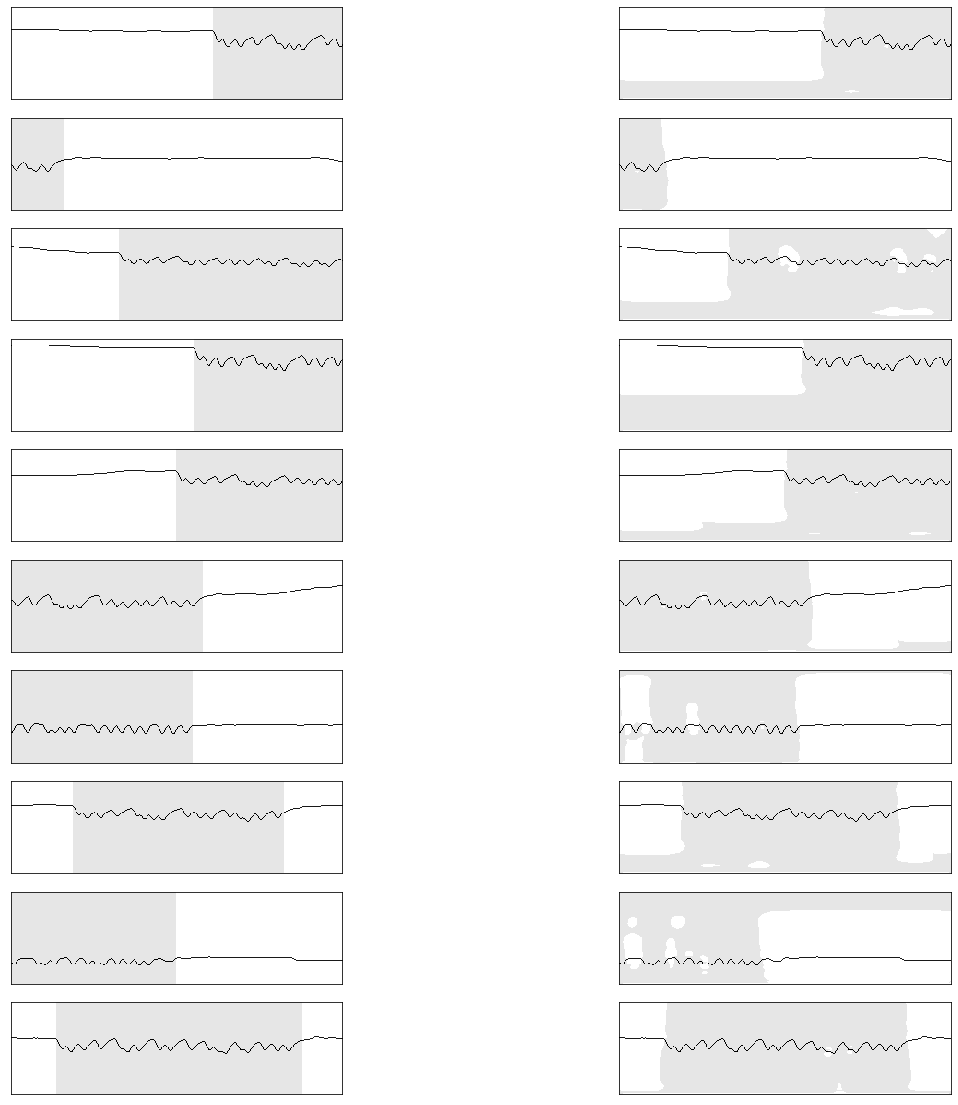

Epoch [3/10], Step [10/96], Loss: 0.358618
Epoch [3/10], Step [20/96], Loss: 0.346946
Epoch [3/10], Step [30/96], Loss: 0.311049
Epoch [3/10], Step [40/96], Loss: 0.152584
Epoch [3/10], Step [50/96], Loss: 1.044204
Epoch [3/10], Step [60/96], Loss: 0.211204
Epoch [3/10], Step [70/96], Loss: 0.210012
Epoch [3/10], Step [80/96], Loss: 0.118719
Epoch [3/10], Step [90/96], Loss: 0.145773


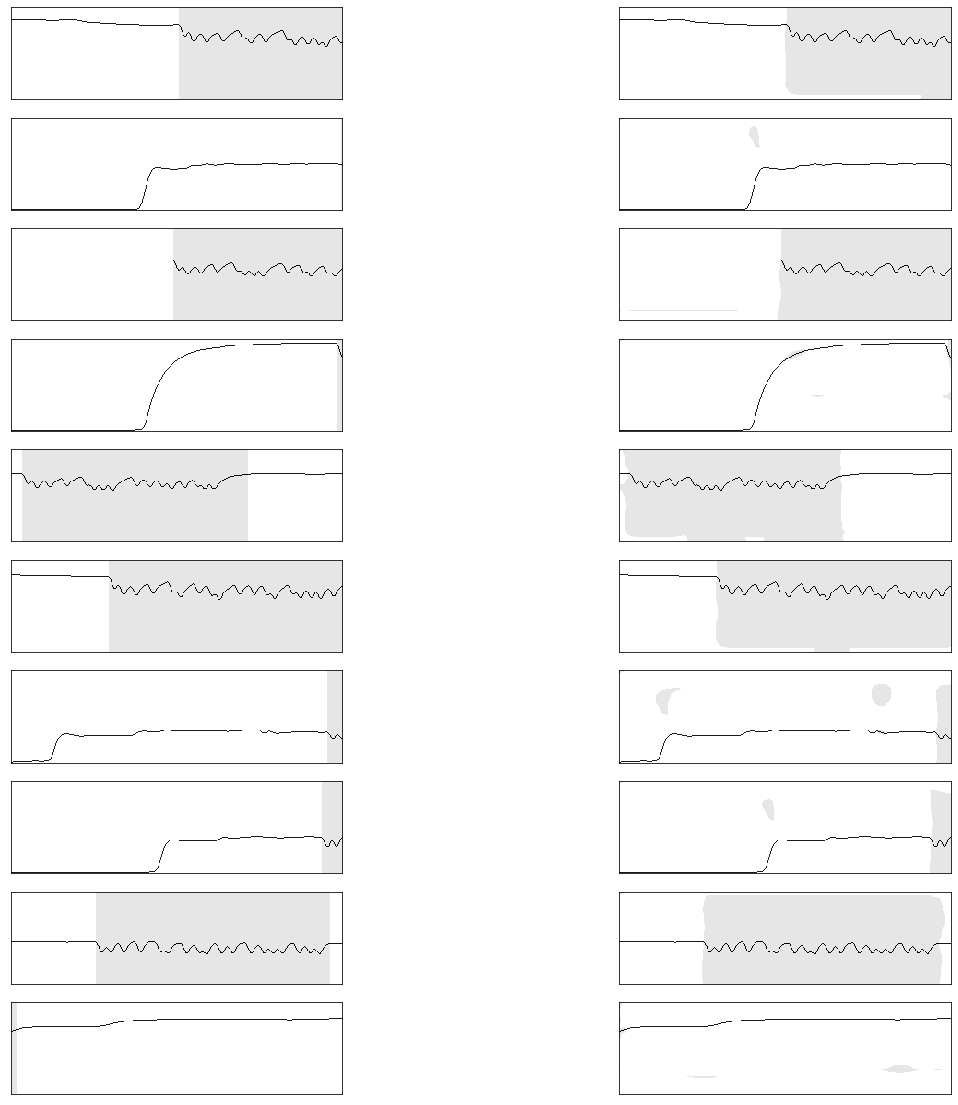

Epoch [4/10], Step [10/96], Loss: 0.086936
Epoch [4/10], Step [20/96], Loss: 0.092847
Epoch [4/10], Step [30/96], Loss: 0.112424
Epoch [4/10], Step [40/96], Loss: 0.070882
Epoch [4/10], Step [50/96], Loss: 0.089639
Epoch [4/10], Step [60/96], Loss: 0.055320
Epoch [4/10], Step [70/96], Loss: 0.051950
Epoch [4/10], Step [80/96], Loss: 0.074478
Epoch [4/10], Step [90/96], Loss: 0.087507


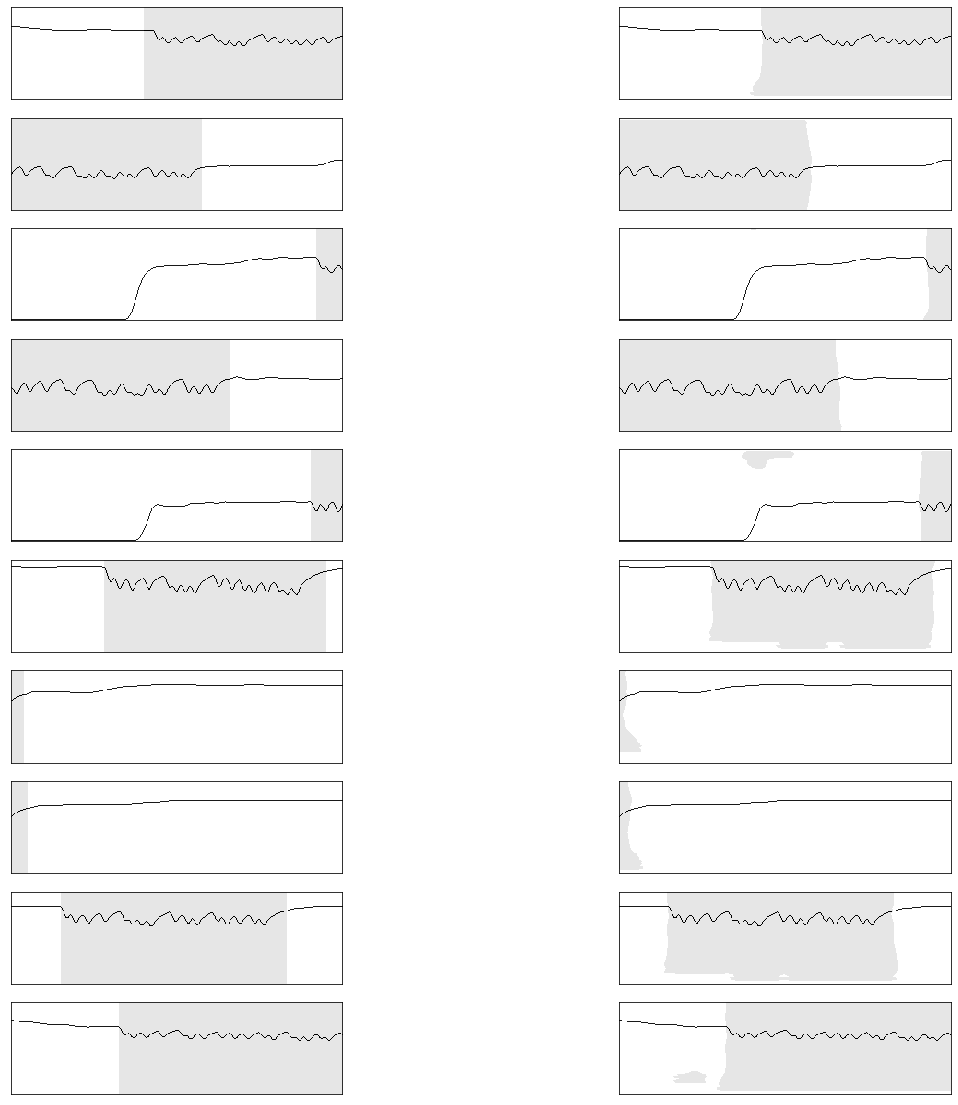

Epoch [5/10], Step [10/96], Loss: 0.195978
Epoch [5/10], Step [20/96], Loss: 0.078753
Epoch [5/10], Step [30/96], Loss: 0.085421
Epoch [5/10], Step [40/96], Loss: 0.106071
Epoch [5/10], Step [50/96], Loss: 0.083125
Epoch [5/10], Step [60/96], Loss: 0.074783
Epoch [5/10], Step [70/96], Loss: 0.072017
Epoch [5/10], Step [80/96], Loss: 0.069319
Epoch [5/10], Step [90/96], Loss: 0.073580


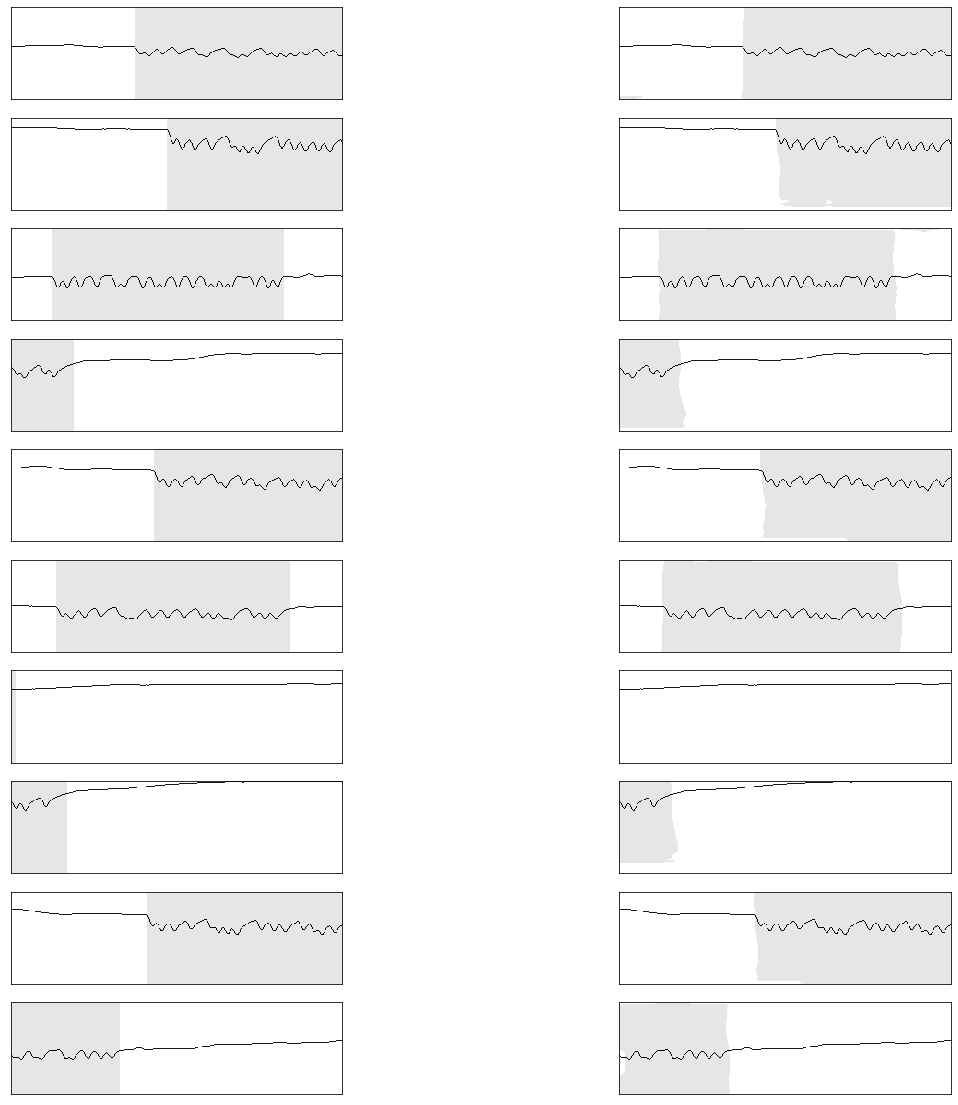

Epoch [6/10], Step [10/96], Loss: 0.048684
Epoch [6/10], Step [20/96], Loss: 0.167051
Epoch [6/10], Step [30/96], Loss: 0.068039
Epoch [6/10], Step [40/96], Loss: 0.084405
Epoch [6/10], Step [50/96], Loss: 0.077429
Epoch [6/10], Step [60/96], Loss: 0.067174
Epoch [6/10], Step [70/96], Loss: 0.048148
Epoch [6/10], Step [80/96], Loss: 0.064874
Epoch [6/10], Step [90/96], Loss: 0.082988


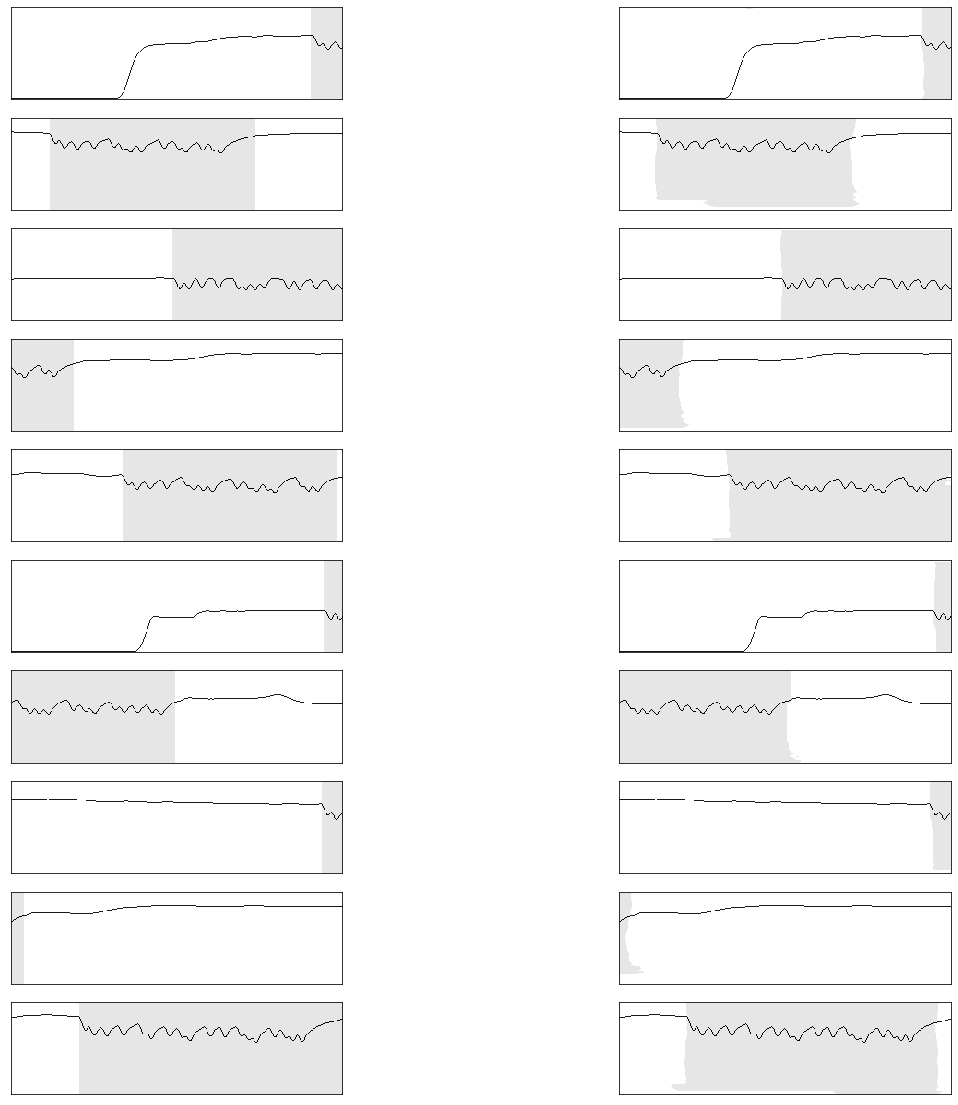

Epoch [7/10], Step [10/96], Loss: 0.077089
Epoch [7/10], Step [20/96], Loss: 0.055515
Epoch [7/10], Step [30/96], Loss: 0.172738
Epoch [7/10], Step [40/96], Loss: 0.044336
Epoch [7/10], Step [50/96], Loss: 0.140724
Epoch [7/10], Step [60/96], Loss: 0.056893
Epoch [7/10], Step [70/96], Loss: 0.060266
Epoch [7/10], Step [80/96], Loss: 0.058910
Epoch [7/10], Step [90/96], Loss: 0.083460


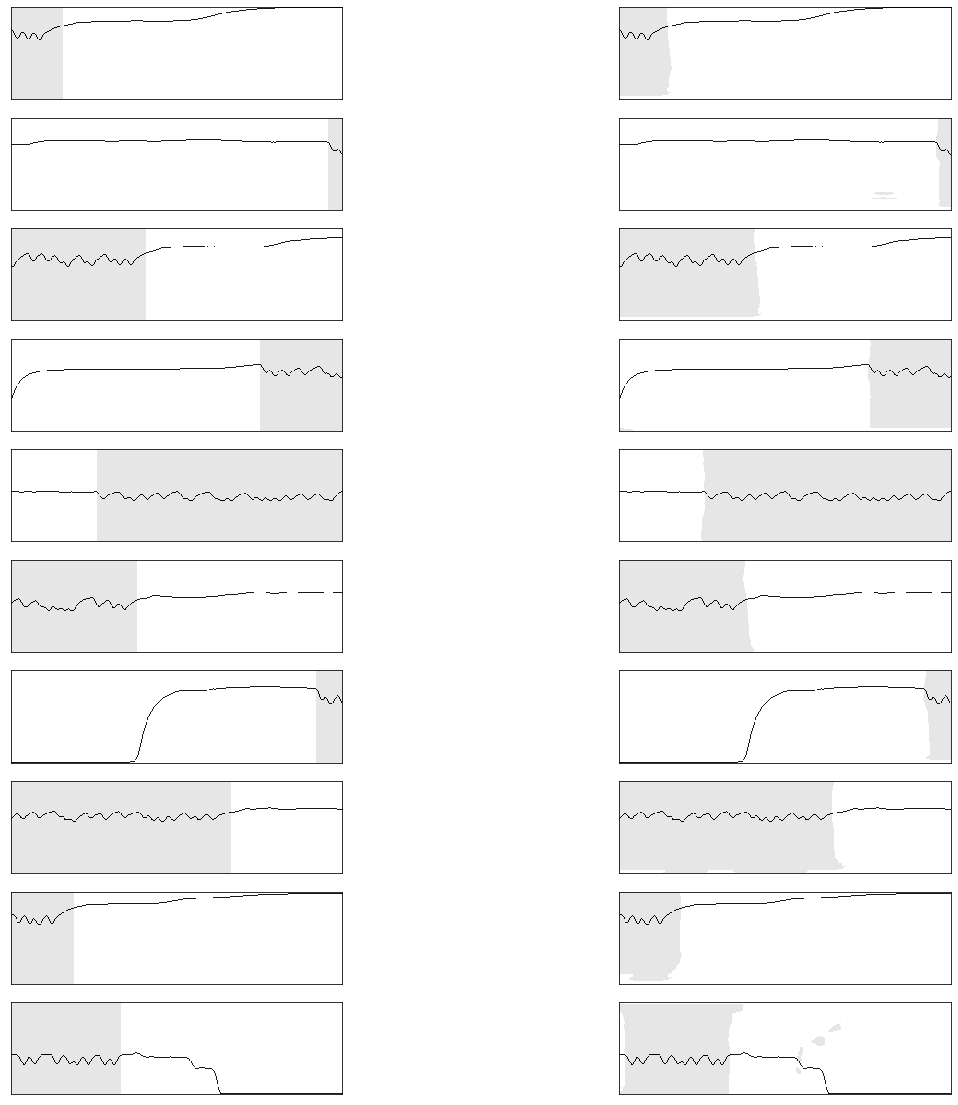

Epoch [8/10], Step [10/96], Loss: 0.051990
Epoch [8/10], Step [20/96], Loss: 0.096476
Epoch [8/10], Step [30/96], Loss: 0.040937
Epoch [8/10], Step [40/96], Loss: 0.037573
Epoch [8/10], Step [50/96], Loss: 0.067410
Epoch [8/10], Step [60/96], Loss: 0.055985
Epoch [8/10], Step [70/96], Loss: 0.157873
Epoch [8/10], Step [80/96], Loss: 0.089565
Epoch [8/10], Step [90/96], Loss: 0.156194


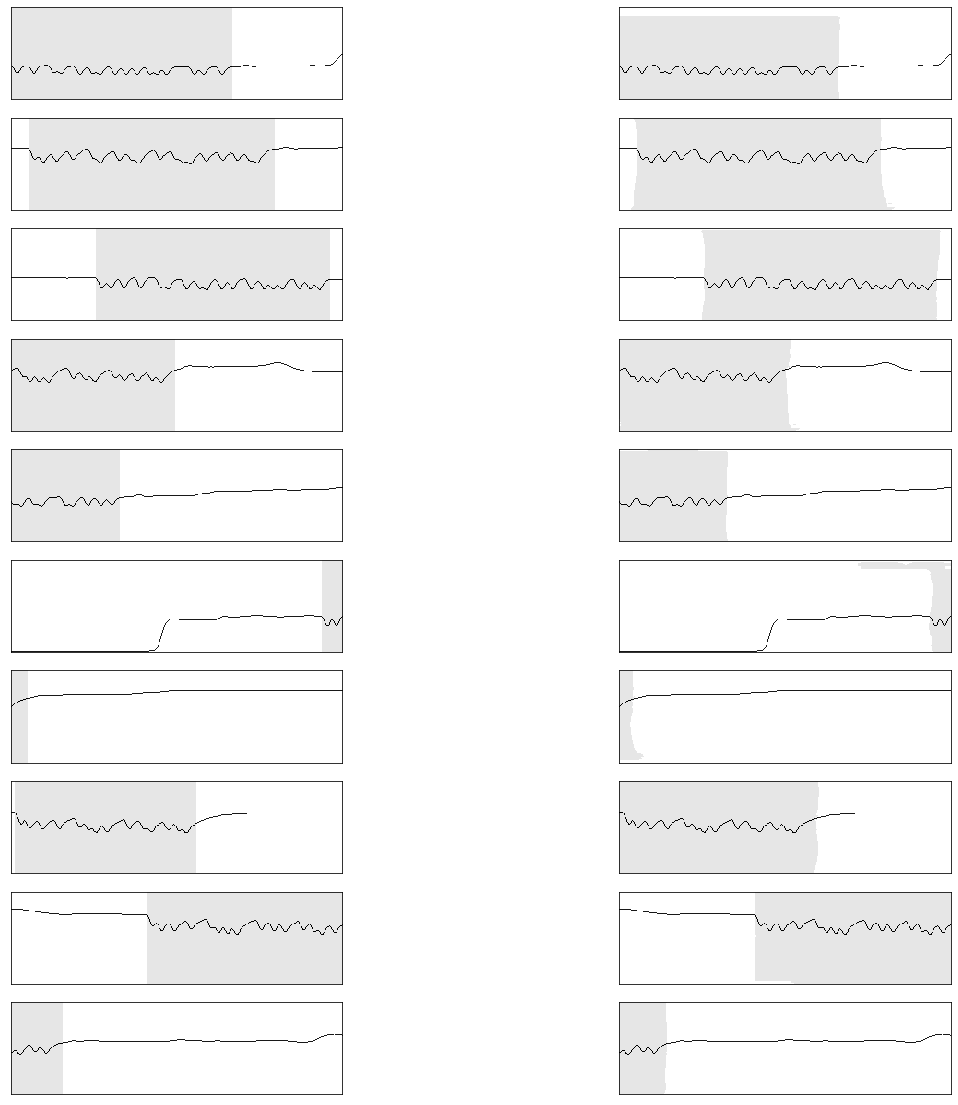

Epoch [9/10], Step [10/96], Loss: 0.055323
Epoch [9/10], Step [20/96], Loss: 0.080269
Epoch [9/10], Step [30/96], Loss: 0.149391
Epoch [9/10], Step [40/96], Loss: 0.093372
Epoch [9/10], Step [50/96], Loss: 0.054385
Epoch [9/10], Step [60/96], Loss: 0.058153
Epoch [9/10], Step [70/96], Loss: 0.067967
Epoch [9/10], Step [80/96], Loss: 0.073368
Epoch [9/10], Step [90/96], Loss: 0.073854


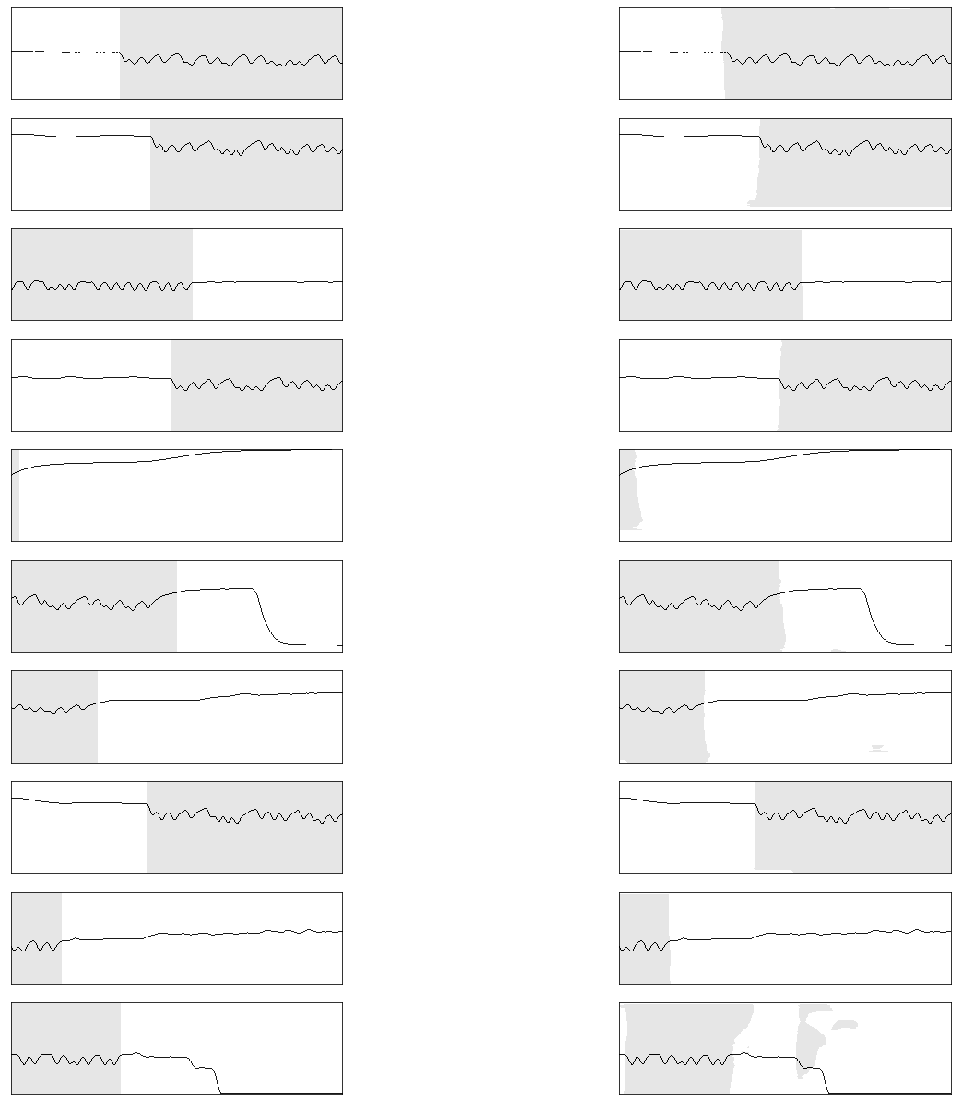

Epoch [10/10], Step [10/96], Loss: 0.072501
Epoch [10/10], Step [20/96], Loss: 0.071870
Epoch [10/10], Step [30/96], Loss: 0.051426
Epoch [10/10], Step [40/96], Loss: 0.057732
Epoch [10/10], Step [50/96], Loss: 0.079625
Epoch [10/10], Step [60/96], Loss: 0.083061
Epoch [10/10], Step [70/96], Loss: 0.104534
Epoch [10/10], Step [80/96], Loss: 0.304952
Epoch [10/10], Step [90/96], Loss: 0.113775


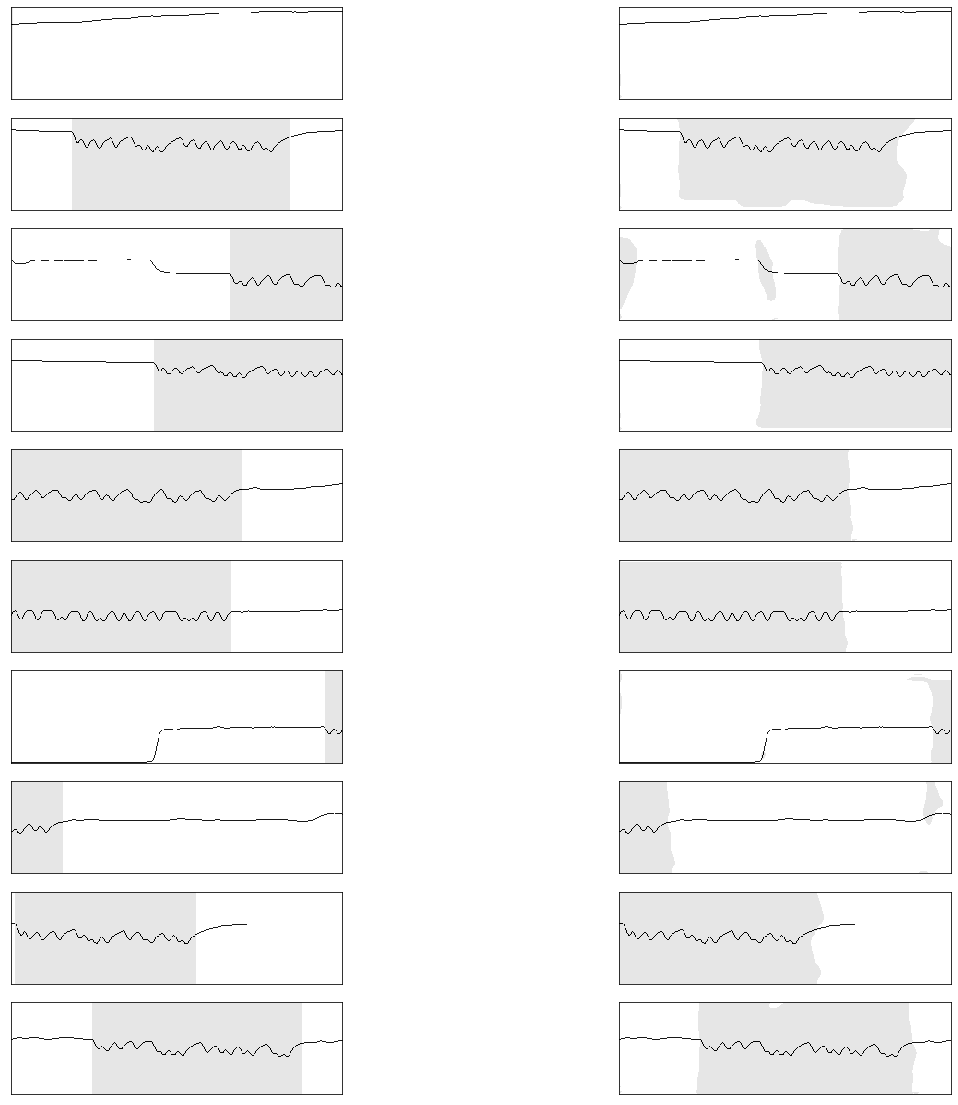

In [13]:
total_steps = len(dataloader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

for epoch in range(epochs):
    for i, (images, masks) in enumerate(dataloader, 1):
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        softmax = F.log_softmax(outputs, dim=1)
        loss = criterion(softmax, masks)
        #running_loss.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 10 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")
            
    running_loss.append(loss.item())        
    # end of each epoch lets print out a sample
    #print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")
    with torch.no_grad():
        val_images, val_masks = dataset.get_valid_batch(10)
        val_images = val_images.to(device)
        preds = model(val_images)
        preds = F.log_softmax(preds, dim=1)
        preds = preds.argmax(dim=1).reshape(10,1,100,360)
        show_side_by_side(val_images.cpu(), val_masks.cpu(), preds.cpu())

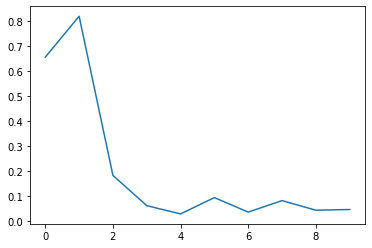

In [14]:
plt.plot(running_loss)